In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"


#General packages
import numpy as np
from My_Jampy import JAM
import emcee

#MPI
from schwimmbad import MPIPool

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

#Autolens Model packages
import autolens as al
import autolens.plot as aplt

#Combined Model package
import CombinedModel

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#Dataset path
data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/New_models/Data/"


In [4]:
#Reading MGE inputs
            #attention to units
surf_lum, sigma_lum, qobs_lum = np.loadtxt(data_folder+"JAM_Input.txt", unpack=True)       #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt(data_folder+"SDP81_pseudo-DM.txt", unpack=True) #DM component
norm_psf, sigma_psf           = np.loadtxt(data_folder+"MUSE_Psf_model.txt", unpack=True)  #PSF
ybin, xbin, vrms, erms        = np.loadtxt(data_folder+"pPXF_rot_data.txt", unpack=True)   #Vrms data

muse_pixsize = 0.2                                  #Muse pixel size [arcsec/px]

z_lens   = 0.299                                    #Lens redshifth
z_source = 3.042                                    #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                   #Lens              
D_s = cosmo.angular_diameter_distance(z_source)                 #Source
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)   #Lens to source

## Models inicialization

"""
    To inicialize the model, we set some random values for the parameters. But it's only necessary for initialize the model. During the non-linear search, this values will be updated constantly until the best fit.
"""  


#This quantities are our unknown parameters
inc       = 75                              #Inclination [deg]
mbh       = 1e10                            #Mass of black hole [M_sun]
beta      = np.full_like(surf_lum, 0.3)     #Anisotropy
ml        = 10                              #Mass to light ratio [M_sun/L_sun]
mag_shear = 0.01                            #Shear magnitude
phi_shear = 100.0                           #Shear angle
rho_s     = 1e10                            #dark matter intensity
qdm       = np.full_like(qobs_dm, 0.5)      #dark matter axial ratio
gamma     = 1.0                             #Gamma
#--------------------------------------------------------------------------------------------------#
# JAMPY MODEL

Jam_model = JAM(ybin=ybin * muse_pixsize, xbin=xbin * muse_pixsize, inc=inc, distance=D_l.value,
                 mbh=mbh, beta=beta, rms=vrms, erms=erms, normpsf=norm_psf, 
                 sigmapsf=sigma_psf * muse_pixsize, pixsize=muse_pixsize)

    #Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml)
    #Add DM component
Jam_model.DM_component(surf_dm=rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL

imaging = al.Imaging.from_fits(
    image_path=f"{data_folder}/ALMA_resampled.fits",
    noise_map_path=f"{data_folder}/ALMA_rms_noise_map.fits",
    psf_path=f"{data_folder}/alma_psf.fits",
    pixel_scales=0.01,
    image_hdu=1, noise_map_hdu=1
)

mask_custom = al.Mask.from_fits(
    file_path=f"{data_folder}mask2.fits", pixel_scales=imaging.pixel_scales
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom)

mass_profile = al.mp.MGE()

    #Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                   surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                   mbh=mbh, surf_dm =rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)
#--------------------------------------------------------------------------------------------------#
# COMBINED MODEL

    #Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                             masked_imaging=masked_imaging, quiet=False)

model.mass_to_light(ml_kind='scalar')               #Setting gradient ML
model.beta(beta_kind='scalar')                      #Seting vector anisotropy
model.has_DM(a=True,filename=data_folder+"SDP81_pseudo-DM.txt") #Setting Dark matter component

In [5]:
def call_model(x0):
    print(x0)
    value =  model(x0)
    print(value)
    if np.isfinite(value):
        return -value
    else:
        return 1e200

In [28]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma
bounds = [(1, 12), (-3, 3), (50, 90), (6, 12), (7, 11), (0.2, 1), (0, 0.1), (0, 179), (0.8, 1.2)]

In [29]:
from scipy.optimize import differential_evolution

In [30]:
result = differential_evolution(call_model, bounds=bounds, updating='deferred', disp=True)

[1.29573845e+00 6.48954629e-01 5.68609487e+01 1.15056139e+01
 6.77743348e+00 8.44100013e-01 3.06846353e-02 4.04539879e+01
 9.51721893e-01]
-inf
[ 9.46274432e+00 -2.33169608e+00  6.23700910e+01  9.99919805e+00
  7.73221390e+00  2.37770158e-01  1.29180490e-03  1.17947432e+02
  8.98123236e-01]
-inf
[ 9.13070210e+00 -2.59810824e+00  8.39264535e+01  7.68931966e+00
  6.12660238e+00  8.30420436e-01  7.37989172e-02  1.74967319e+02
  1.09188049e+00]
-5255050.473015658
[2.22304646e+00 8.31163992e-01 5.22643131e+01 8.29170795e+00
 9.88286955e+00 5.40343117e-01 7.99883629e-02 8.94889085e+01
 8.53074684e-01]
-inf
[ 9.33432686e+00 -3.15179064e-02  7.89901106e+01  6.39786899e+00
  1.19620523e+01  3.00689078e-01  5.89559258e-03  2.09660985e+01
  9.12130962e-01]
-inf
[ 4.99963802e+00 -2.88129190e+00  5.04478611e+01  6.27072262e+00
  8.62650285e+00  3.09317492e-01  9.73584107e-02  1.70586136e+02
  9.34679585e-01]
-inf
[3.01456142e+00 1.16928466e+00 5.75882659e+01 8.36552065e+00
 6.29879886e+00 4.5695855

-6596045.051659425
[ 6.7393675   1.74056356 73.03198884  7.88768524  7.97540962  0.39389802
  0.08852993 53.47254887  0.91917003]
-18549354.465122666
[10.10633438  2.61627487 64.08784922  6.63090188  9.22539182  0.94905475
  0.06821055 39.3129829   1.07974662]
-inf
[10.75633738  2.00027735 59.17105516  8.93396111  6.58317042  0.66503922
  0.0649555  56.5198302   0.80549636]
-15510853.681749796
[11.3796143  -1.54366835 52.7030988   8.32288431 10.08456371  0.85344697
  0.09816291 86.63798745  0.8233813 ]
-inf
[ 9.03548194e+00 -1.32384846e+00  5.47902611e+01  8.92856076e+00
  1.05215361e+01  6.40599763e-01  2.25566464e-02  7.37016214e+01
  8.96080230e-01]
-inf
[ 6.12181394e+00 -2.84661301e+00  7.37397453e+01  7.25130396e+00
  8.21063758e+00  3.96118126e-01  5.44696191e-02  1.19759414e+02
  9.94572461e-01]
-20289223.36678725
[ 1.797965    0.38023784 60.52835551  6.68731428 10.77781334  0.46092555
  0.0895316  33.03235327  0.82624966]
-inf
[3.33817219e+00 1.35338182e-01 8.74187771e+01 1.116

-1648777.5413554288
[ 1.17493590e+00 -1.46707935e+00  7.61282846e+01  1.10779562e+01
  7.56311357e+00  4.10854391e-01  7.83196910e-02  1.10953551e+02
  1.18329286e+00]
-inf
[ 7.69231533e+00 -1.98508043e+00  5.55164172e+01  8.19789896e+00
  6.86404792e+00  3.58098463e-01  4.06384788e-02  6.70917216e+01
  9.48213892e-01]
-inf
[ 1.18759451e+01 -1.17107852e+00  5.10926608e+01  9.70819173e+00
  1.19250046e+01  4.23205549e-01  8.79224595e-02  1.48211155e+02
  1.17557108e+00]
-inf
[ 9.95572206  1.47264947 70.37820023 10.42648496  9.39094209  0.2928532
  0.07429059 26.05939453  1.06537922]
-inf
[1.03821729e+01 8.12923892e-01 7.27493832e+01 9.55610736e+00
 9.67969155e+00 4.93666289e-01 3.02040868e-02 1.15253824e+01
 8.12037962e-01]
-27504892.15419532
[ 7.18598884e+00 -9.08334331e-01  6.10918947e+01  1.13993259e+01
  8.28422712e+00  6.37546596e-01  5.96735142e-02  2.50925727e+01
  9.82894342e-01]
-inf
[1.16497482e+01 1.25651800e+00 8.26697495e+01 6.16116797e+00
 6.88971780e+00 5.74459456e-01 7.7

-5681437.567003783
[7.26545265e+00 9.23953050e-01 7.23382877e+01 6.98893800e+00
 7.58703165e+00 6.78286737e-01 9.30502557e-02 1.67730498e+02
 9.09103877e-01]
-inf
[ 1.85997748e+00 -7.46697001e-01  6.22172123e+01  9.76794838e+00
  1.02911512e+01  6.75226036e-01  9.96985123e-03  1.56587760e+02
  1.12402756e+00]
-1057768.4439275844
[ 2.46599656 -2.99649769 54.27644696  6.26196858  9.21833535  0.77120092
  0.06891456  9.72968784  1.12054605]
-inf
[ 1.85792692e+00 -2.04559706e+00  8.70156089e+01  6.92032497e+00
  8.51691180e+00  7.82343906e-01  6.77909704e-02  7.60299173e+01
  9.85149519e-01]
-inf
[8.11192151e+00 4.93828635e-01 7.93588969e+01 7.64024613e+00
 8.14686400e+00 5.14685150e-01 3.74181348e-02 1.24404862e+02
 9.06026431e-01]
-40212357.06112611
[1.03181507e+01 7.19726708e-01 8.81444406e+01 1.10047277e+01
 6.83242947e+00 6.21788610e-01 5.95357499e-02 1.17581602e+01
 9.84817534e-01]
-inf
[1.14166132e+01 5.51297267e-01 6.67335546e+01 8.69796274e+00
 8.80137261e+00 7.05505779e-01 3.5564

KeyboardInterrupt: 

In [6]:
pos = np. array([ 4.31572778, -1.27486421, 60.82490136,  7.51042467, 11.99247237,
        0.96681472,  0.06682769, 40.22870216,  1.04801109])


[ 4.31572778 -1.27486421 60.82490136  7.51042467 11.99247237  0.96681472
  0.06682769 40.22870216  1.04801109]
ParsDic {'ml': 4.31572778, 'beta': -1.27486421, 'inc': 60.82490136, 'log_mbh': 7.51042467, 'log_rho_s': 11.99247237, 'qDM': 0.96681472, 'mag_shear': 0.06682769, 'phi_shear': 40.22870216, 'gamma': 1.04801109}
jam_axi_rms elapsed time sec: 0.35
inc=60.8 beta_z=-1.27 M/L=1 BH=3.24e+07 chi2/DOF=11.5
Total mass MGE: 2.044e+13


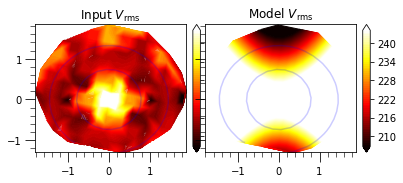

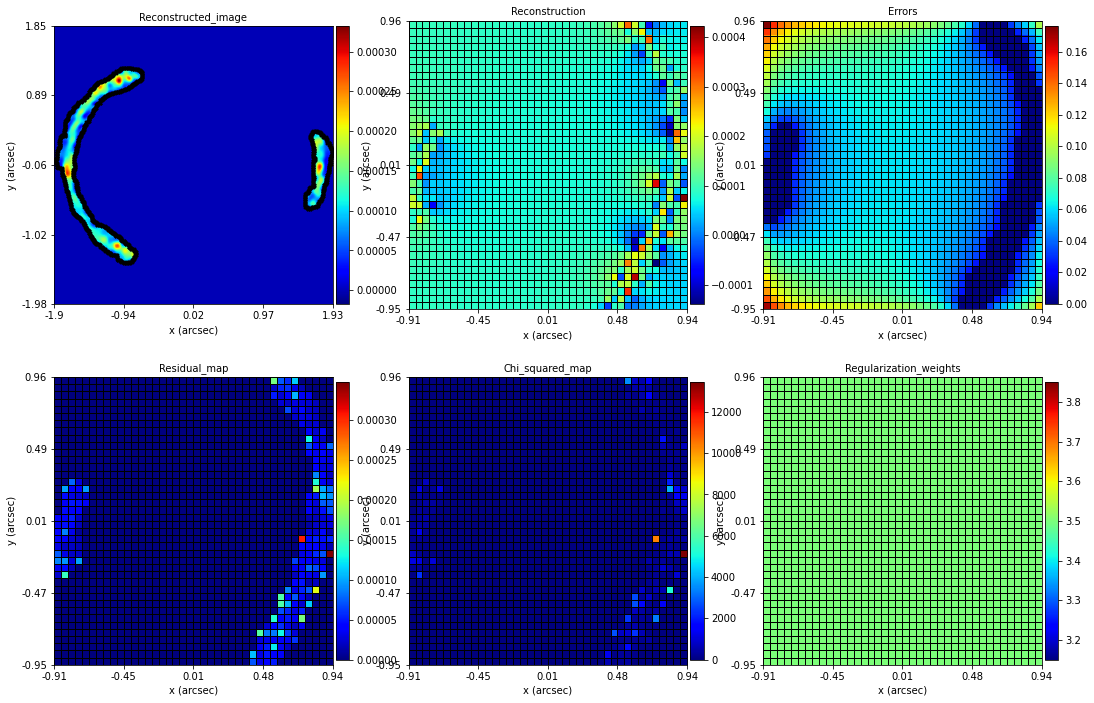

-68636.39590704505


68636.39590704505

In [7]:
call_model(pos)